# IMPACT paper experiments
### 1. Init
#### 1.1. Import libraries (necessary)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from liriscat import utils
utils.set_seed(0)
from liriscat import dataset
from liriscat import selectionStrategy
from liriscat import CDM

import logging
import gc
import json
import torch
import pandas as pd
from importlib import reload
import IMPACT

#### 1.2. Set up the loggers (recommended)

In [2]:
utils.setuplogger(verbose = True, log_name="liriscat")

### 2. CDM prediction
#### 2.1. Training and testing, sequential version

In [3]:
import warnings
import numpy as np

gc.collect()
torch.cuda.empty_cache()

reload(utils)
reload(selectionStrategy)
reload(CDM)
reload(dataset)

<module 'liriscat.dataset' from '/home/arthurb/Programmation/liriscat/liriscat/dataset/__init__.py'>

In [4]:
config = utils.generate_eval_config(esc = 'error', valid_metric= 'mi_acc', pred_metrics = ["mi_acc"], profile_metrics = ['doa'], save_params=False, n_query=5, num_epochs=0, batch_size=512)
utils.set_seed(config["seed"])

config["dataset_name"] = "math2"
logging.info(config["dataset_name"])
config['learning_rate'] = 0.02026
config['lambda'] = 1.2e-5
config['d_in'] = 4
config['num_responses'] = 12
#pred_metrics,df_interp = test(config)

CUDA is available. Using GPU.
[INFO 23:20] math2


In [5]:
logging.info(f'#### {config["dataset_name"]} ####')
logging.info(f'#### config : {config} ####')
config['embs_path']='../embs/'+str(config["dataset_name"])
config['params_path']='../ckpt/'+str(config["dataset_name"])

pred_metrics = {m:[] for m in config['pred_metrics']}
profile_metrics = {m:[] for m in config['profile_metrics']}

gc.collect()
torch.cuda.empty_cache()

# Dataset downloading for doa and rm
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Concept map format : {question_id : [category_id1, category_id2, ...]}
concept_map = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

## Metadata map format : {"num_user_id": ..., "num_item_id": ..., "num_dimension_id": ...}
metadata = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'))

[INFO 23:20] #### math2 ####
[INFO 23:20] #### config : {'seed': 0, 'dataset_name': 'math2', 'load_params': False, 'save_params': False, 'embs_path': '../embs/', 'params_path': '../ckpt/', 'early_stopping': True, 'esc': 'error', 'verbose_early_stopping': False, 'disable_tqdm': False, 'valid_metric': 'mi_acc', 'learning_rate': 0.02026, 'batch_size': 512, 'num_epochs': 0, 'eval_freq': 1, 'patience': 30, 'device': device(type='cuda'), 'lambda': 1.2e-05, 'tensorboard': False, 'flush_freq': True, 'pred_metrics': ['mi_acc'], 'profile_metrics': ['doa'], 'num_responses': 12, 'low_mem': False, 'n_query': 6, 'CDM': 'impact', 'd_in': 4} ####


In [6]:
i_fold = 0
## Dataframe columns : (user_id, question_id, response, category_id)
train_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
valid_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
test_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})

In [9]:
reload(dataset)
train_data = dataset.CATDataset(train_df, concept_map, metadata, config, config['batch_size'])
valid_data = dataset.evalDataset(valid_df, concept_map, metadata, config, batch_size=10000, pin_memory=True)
test_data = dataset.evalDataset(test_df, concept_map, metadata, config, batch_size=10000, pin_memory=True)

/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:150: UserWarning: The torch_array contains both query and the meta set !
  warnings.warn("The torch_array contains both query and the meta set !")
/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:155: UserWarning: The log_tensor contains both query and the meta set !
  warnings.warn("The log_tensor contains both query and the meta set !")
/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:160: UserWarning: The user_dict contains both query and the meta set !
  warnings.warn("The user_dict contains both query and the meta set !")


In [10]:
reload(utils)
reload(selectionStrategy)
reload(dataset)
reload(CDM)

S = selectionStrategy.Random(**config)
S.train(train_data, valid_data)

RandomModel()
[INFO 24:15] train on cuda
[INFO 24:15] -- START Training --


0it [00:06, ?it/s]


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/arthurb/Programmation/liriscat/liriscat/CDM/IMPACT.py", line 683, in <forward op>
    v_mask = concepts_id.unsqueeze(0).eq(concepts_id.unsqueeze(1))  # same concept checking
    u_mask = v_mask & (b_diag > 0.0) & (
                R_t >= 1.0)  # b_diag > 0 : not exactly similar responses for which we cannot say anything; R_t >= 1.0 : comparison with not null responses only
                ~~~~~~~~~~ <--- HERE

    indices = torch.nonzero(u_mask)
RuntimeError: CUDA out of memory. Tried to allocate 214.00 MiB. GPU 0 has a total capacity of 3.71 GiB of which 24.62 MiB is free. Including non-PyTorch memory, this process has 2.35 GiB memory in use. Of the allocated memory 2.20 GiB is allocated by PyTorch, and 67.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)



In [ ]:
test_data.split_query_meta(2)
S.evaluate_test(test_data)

In [15]:
saved_mi_acc = [0.643, 0.6379999999999999, 0.645, 0.661, 0.6679999999999999, 0.675, 0.6890000000000001, 0.7010000000000001]

saved_doa = [0.506,0.564,0.576,0.588,0.604,0.612,0.685,0.702]

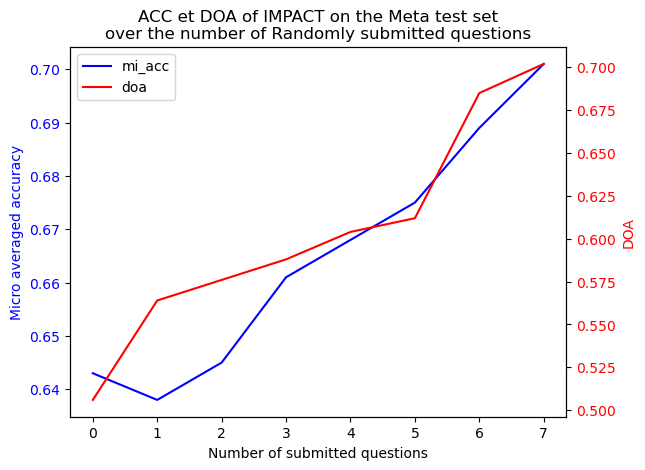

In [22]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# First plot
color1 = 'b'
ln1 = ax1.plot(saved_mi_acc, color1, label='mi_acc')
ax1.set_xlabel('Number of submitted questions')
ax1.set_ylabel('Micro averaged accuracy', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Twin axis for second plot
ax2 = ax1.twinx()
color2 = 'r'
ln2 = ax2.plot(saved_doa, color2, label='doa')
ax2.set_ylabel('DOA', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='best')

plt.title('ACC et DOA of IMPACT on the Meta test set\nover the number of Randomly submitted questions')
plt.show()
